# Task

With AI-modelling and Data Science there is plenty of opportunity to improve processes or suggest improved ways of doing things. When doing so it is often very smart and efficient (time is a scarce resource) to create a POC (Proof of Concept) which basically is a small demo checking wether it is worthwile going further with something. It is also something concrete which facilitates discussions, do not underestimate the power of that. 

In this example, you are working in a company that sells houses and they have a "manual" process of setting prices by humans. You as a Data Scientist can make this process better by using Machine Learning. Your task is to create a POC that you will present to your team colleagues and use as a source of discussion of wether or not you should continue with more detailed modelling. 

Two quotes to facilitate your reflection on the value of creating a PoC: 

"*Premature optimization is the root of all evil*". 

"*Fail fast*".


**More specifially, do the following:**
1. A short EDA (Exploratory Data Analysis) of the housing data set.
2. Drop the column `ocean_proximity`, then you only have numeric columns which will simplify your analysis. Remember, this is a POC! 
3. You have missing values in your data (not sure you do but you can assume so). Handle this with `SimpleImputer(strategy="median")`. (Check the fantastic Scikit-learn documentation for details.) Notice, the `SimpleImputer` should only be used for transformation on the validation and test data, not fitting.
4. Split your data into `X` and `y`, and then into train, validation and test sets. 
5. Create one `LinearRegression` model and one `Lasso` model. For the `Lasso` model, use `GridSearchCV` to optimize $\alpha$ values. Choose yourself which $\alpha$ values to evaluate.
Use RMSE as a metric to decide which model to choose. 

6. Which model is best on the validation data? 

7. Evaluate your chosen model on the test set using the root mean squared error (RMSE) as the metric. 
What are your conclusions? Note: to be 100% sure, you should re-fit your chosen model on the combination of train+val data. 

8. Do a short presentation (~ 2-5 min) on your POC that you present to your colleagues (no need to prepare anything particular, just talk from the code). Think of:
- What do you want to highlight/present?
- What is your conclusion?
- What could be the next step? Is the POC convincing enough or is it not worthwile continuing? Do we need to dig deeper into this before taking some decisions?

------------
Bonus question for those who have time and are ambitious: Redo everything above (copy your code) but in step 2, include the column `ocean_proximity` which is a categorical column. 

# Code

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

## Load data

In [ ]:
housing = pd.read_csv('data/housing.csv')

housing.drop(columns=['ocean_proximity'], inplace=True) 

y = housing['median_house_value'] 
X = housing.drop(columns=['median_house_value']) # Drop the target variable and the categorical column

## EDA

<AxesSubplot: >

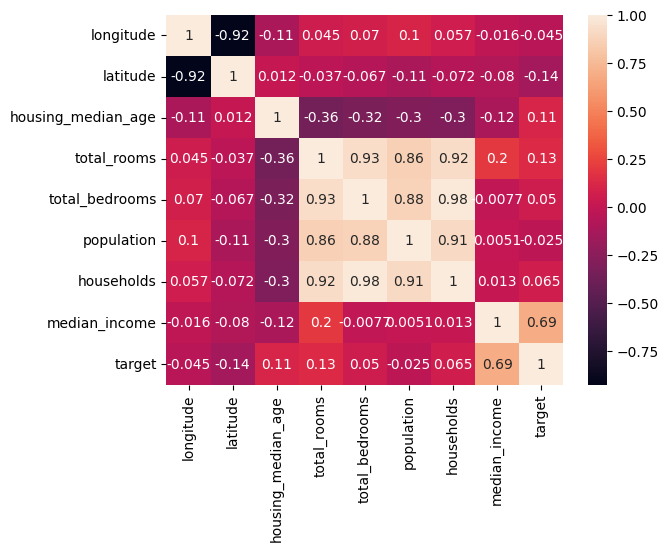

In [73]:
# Placing all the data in "df" so I can make a nice correlation plot
df = X.copy()
df['target'] = y

correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)

## Prepare data

In [83]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

# Split the data into training and temporary sets. 
# We'll further split the temporary set into validation and test sets.
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  # Adjust test_size as needed
)

# Fit the pipeline on the training data to calculate imputation and scaling parameters
pipeline.fit(X_train_temp)

# Transform training, validation, and test data using the fitted pipeline
X_train = pipeline.transform(X_train_temp)
y_train = y_train_temp
X_val, X_test, y_val, y_test = train_test_split(
    pipeline.transform(X_test), y_test, test_size=0.5, random_state=42 #Split test into validation and test.
)

## Models

Validation set

In [84]:
# Linear regression
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

y_val_pred = lin_reg.predict(X_val)
rmse_val_lr = np.sqrt(root_mean_squared_error(y_val, y_val_pred))

print(f"Linear Regression - Validation Set:")
print(f"  RMSE: ${rmse_val_lr:.2f}")


# Lasso regression
lasso = Lasso()
param_grid = {'alpha': np.logspace(-2, 1, 20)} # Explore a range of alpha values
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) #n_jobs=-1 for parallelization.
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
best_lasso = grid_search.best_estimator_

y_val_pred_lasso = best_lasso.predict(X_val)
rmse_val_lasso = np.sqrt(root_mean_squared_error(y_val, y_val_pred_lasso))

print("\nLasso Regression - Validation Set (best alpha):")
print(f"  Best alpha: {best_alpha:.4f}")
print(f"  RMSE: ${rmse_val_lasso:.2f}")

Linear Regression - Validation Set:
  RMSE: $261.96

Lasso Regression - Validation Set (best alpha):
  Best alpha: 6.9519
  RMSE: $261.96


Linear regression - test set

In [ ]:
"""
It's possible that the optimal alpha for the Lasso model is very close to or even the same as if no regularization was applied (alpha approaching 0). 
This would make the Lasso model behave almost identically to Linear Regression. 
If alpha is near zero, that is an indication that regularization isn't helping and the data doesn't strongly benefit from it.
I choose simplicity over complexity here -> linear regression
"""

X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))
lin_reg.fit(X_train_val, y_train_val)

y_test_pred = lin_reg.predict(X_test)
rmse_test = np.sqrt(root_mean_squared_error(y_test, y_test_pred))

print(f"Linear Regression - Test Set:")
print(f"  RMSE: ${rmse_test:.2f}")

Linear Regression - Test Set:
  RMSE: $267.67


## Evaluation

In [90]:
median_house_price = housing['median_house_value'].median()
print(f"Median house price: ${median_house_price:.2f}")
print(f"Median house price / RMSE = {((rmse_test / median_house_price)* 100):.3f} %")

Median house price: $179700.00
Median house price / RMSE = 0.149 %


## Conclusions

Our model achieved an RMSE of $267.67. The median house price is $179,700. This represents approximately 0.15% error relative to the median house price. This level of accuracy is quite good and suggests that the model is performing well enough to warrant further development.